<a href="https://colab.research.google.com/github/CharlesMaponya/Language_Identification_Hackathon/blob/main/Language_Detection_by_Charles_Maponya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle competitions download -c language-identification

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!pip install contractions
!pip install scikit-plot
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.pipeline import Pipeline

# feature extractioin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Train test split
from sklearn.model_selection import train_test_split

# classification models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import lightgbm as lgb

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import contractions

#optimization
#import parfit.parfit as pf
#Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

#Vizualization libraries
from PIL import Image
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from sklearn.metrics import plot_roc_curve
from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline

####**Importing and Preprocessing The Data**

In [ ]:
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

In [ ]:
print('Train Info')
print('-'*40)
train.info()
print('-'*40)
print('Train data view')
train.head()

Train Info
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB
----------------------------------------
Train data view


,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


####**Removing Blank or White space text**

In [ ]:
def drop_blank(df):
  """
  Parameter:
  df: <pandas.core.frame.DataFrame>
    pandas datframe
  returns:
    blanks: list
      returns a list of indexes where there are blank spaces
  """
  blanks=[]
  for i, label,value in df.itertuples():
    if type(value)==str:
      if value.isspace():
        blanks.append(i)
  return blanks

In [ ]:
#Drop Blank spaces in the train data set
train.drop(drop_blank(train),inplace=True)

In [ ]:
#Drop blank spaces in the test dataset
test.drop(drop_blank(test),inplace=True)

####**Cleaning The training and test Data**

In [ ]:
def data_clean(df):
  """
  Parameter:
  df: <pandas.core.frame.DataFrame>
    pandas datframe
  returns:
    df: <pandas.core.frame.DataFrame>
      return a dataframe that has been data wrangled
  """
  df['text'] = df['text'].apply(lambda y: contractions.fix(y))
  df['text']= df['text'].str.replace('-',' ')
  df['text']=df['text'].apply(TweetTokenizer().tokenize)
  df['text']=df['text'].apply(lambda x : [token for token in x if token not in string.punctuation])
  df['text']=df['text'].apply(lambda x: [token for token in x if token not in list(string.digits)])
  df['text']=df['text'].apply(lambda x: [token for token in x if len(token) > 1])
  df['text'] = df['text'].apply(lambda x: [word.lower() for word in x])
  return df

In [ ]:
#Cleaning the train dataset
train_clean =data_clean(train)

In [ ]:
#Cleaning the test dataset
test_clean = data_clean(test)

###**Creating Model Pipelines**

In [ ]:
#Ensuring the training features are strings
X = train_clean['text'].str.join(' ')
y= train_clean['lang_id']
#Ensuring the testing features are strings
X_test = test_clean['text'].str.join(' ')

In [ ]:
#Creating a training and validation data sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state = 42)

In [ ]:
#Naive Bayes Classifiers
naive_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('naive', MultinomialNB()),])

naive_tfidf =Pipeline([('tfidf',  TfidfVectorizer(max_features=180000)),('naive', MultinomialNB()),])

#LinearSVC Clasiffiers
Lsvc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('lsvc', LinearSVC(max_iter=100000)),])

Lsvc_tfidf = Pipeline([('tfidf', TfidfVectorizer(max_features=180000)),('svc', LinearSVC(max_iter=100000)),])

#SVC Classifiers
svc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('SVC', SVC()),])

svc_tfidf = Pipeline([('CountVec',TfidfVectorizer(max_features=180000)),('SVC', SVC()),])

#SGD Classifiers
SGD_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('SGD', SGDClassifier()),])

SGD_tfidf = Pipeline([('CountVec',TfidfVectorizer(max_features=180000) ),('SGD', SGDClassifier()),])

#Ridge Classifers
ridge_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('Ridge', RidgeClassifierCV()),])

ridge_tfidf = Pipeline([('CountVec',TfidfVectorizer(max_features=180000)),('Ridge', RidgeClassifierCV()),])

####Training Our Models

####*Naive Bayes Classifiers*

In [ ]:
naive_count.fit(X_train,y_train)
naive_tfidf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0,
                                 max_features=180000, min_df=1,
                                 ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('naive',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

####*Linear SVC classifiers*

In [ ]:
Lsvc_count.fit(X_train,y_train)
Lsvc_tfidf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0,
                                 max_features=180000, min_df=1,
                                 ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, i

####*SVC classifiers*

In [ ]:
svc_count.fit(X_train,y_train)
svc_tfidf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('CountVec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0,
                                 max_features=180000, min_df=1,
                                 ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SVC',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0

####*SGD Classifiers*

In [ ]:
SGD_count.fit(X_train,y_train)
SGD_tfidf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('CountVec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0,
                                 max_features=180000, min_df=1,
                                 ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='op

####**Ridge Classsifers**

**Be careful here.. This model has a tendency of consuming too much RAM and processing power**

In [ ]:
ridge_count.fit(X_train,y_train)
ridge_tfidf.fit(X_train,y_train)

###**Model Evaluation**

#####**Naive Bayes Models**

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       0.99      1.00      1.00       297
         nbl       1.00      1.00      1.00       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       0.99      0.99      0.99       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.99      0.99      0.99       313
         zul       0.99      0.99      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Naive Bayes Classifier with Count Vectorizer')

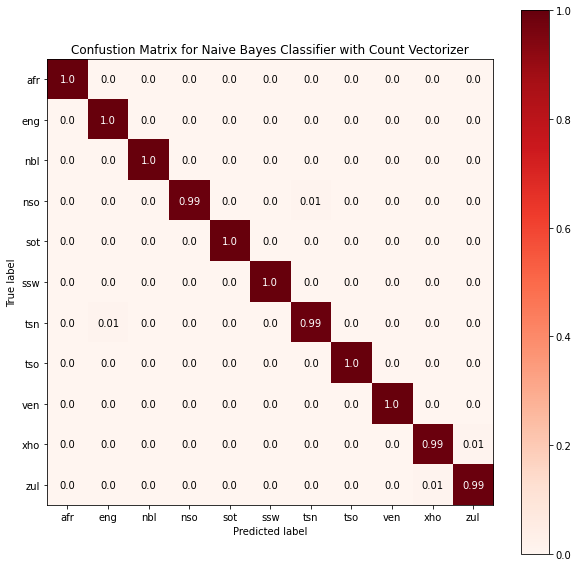

In [ ]:
print(classification_report(y_val,naive_count.predict(X_val)))
plot_confusion_matrix(y_val,naive_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for Naive Bayes Classifier with Count Vectorizer")

              precision    recall  f1-score   support

         afr       0.99      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      1.00      1.00       327
         nso       1.00      1.00      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       1.00      1.00      1.00       313
         zul       1.00      1.00      1.00       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Naive Bayes Classifier with TF-IDF Vectorizer')

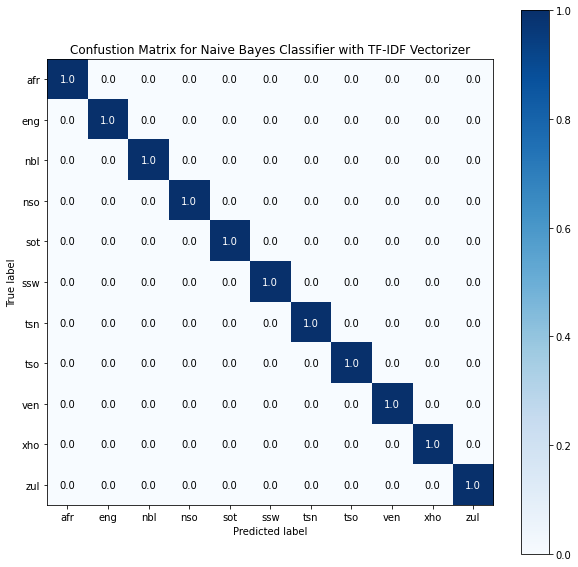

In [ ]:
print(classification_report(y_val,naive_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,naive_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for Naive Bayes Classifier with TF-IDF Vectorizer")

#####**Linear SVC Models**

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      0.99      1.00       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       0.99      1.00      0.99       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       1.00      1.00      1.00       313
         zul       0.99      1.00      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Linear SVC Classifier with Count Vectorizer')

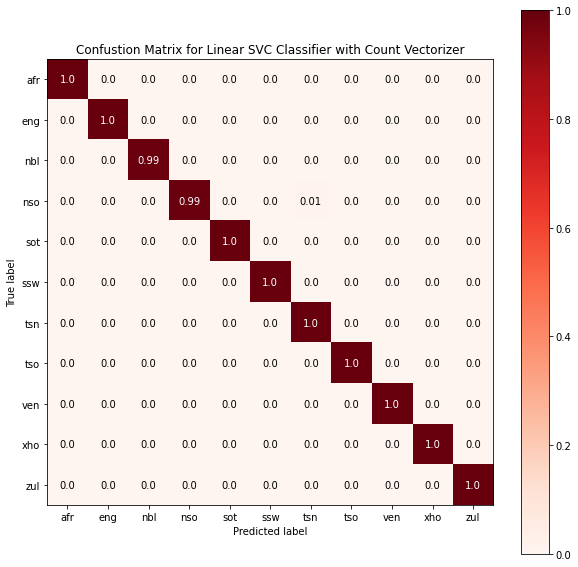

In [ ]:
print(classification_report(y_val,Lsvc_count.predict(X_val)))
plot_confusion_matrix(y_val,Lsvc_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for Linear SVC Classifier with Count Vectorizer")

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      0.99      1.00       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       0.99      1.00      0.99       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.99      1.00      1.00       313
         zul       0.99      0.99      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Linear SVC Classifier with TF-IDF Vectorizer')

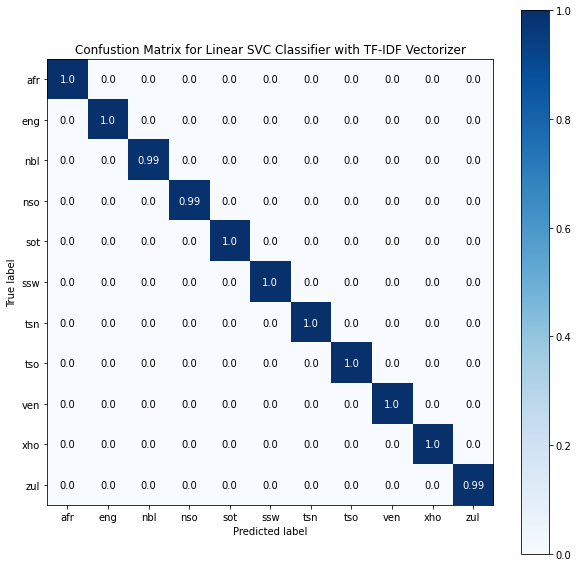

In [ ]:
print(classification_report(y_val,Lsvc_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,Lsvc_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for Linear SVC Classifier with TF-IDF Vectorizer")

#####**SVC Models**

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       0.99      0.98      0.99       327
         nso       1.00      0.99      0.99       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       0.99      1.00      0.99       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.98      0.99      0.99       313
         zul       0.97      0.98      0.98       295

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



Text(0.5, 1.0, 'Confustion Matrix for SVC Classifier Count Vectorizer')

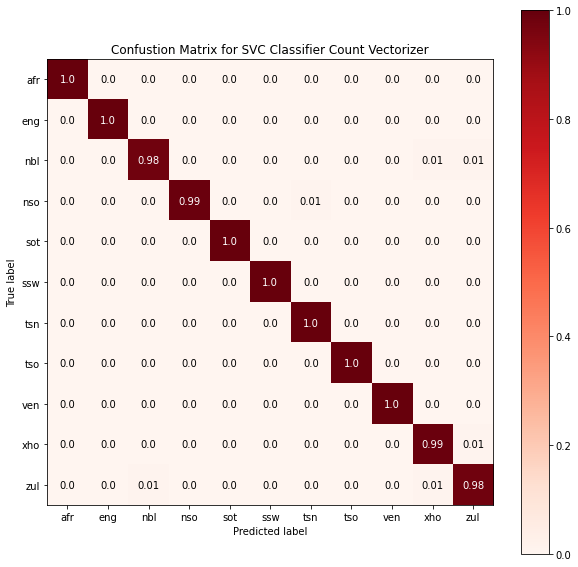

In [ ]:
print(classification_report(y_val,svc_count.predict(X_val)))
plot_confusion_matrix(y_val,svc_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for SVC Classifier Count Vectorizer")

              precision    recall  f1-score   support

         afr       1.00      0.99      1.00       281
         eng       1.00      0.99      0.99       297
         nbl       1.00      0.98      0.99       327
         nso       1.00      0.99      0.99       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.98      1.00      0.99       313
         zul       0.96      1.00      0.98       295

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



Text(0.5, 1.0, 'Confustion Matrix for SVC Classifier with TF-IDF Vectorizer')

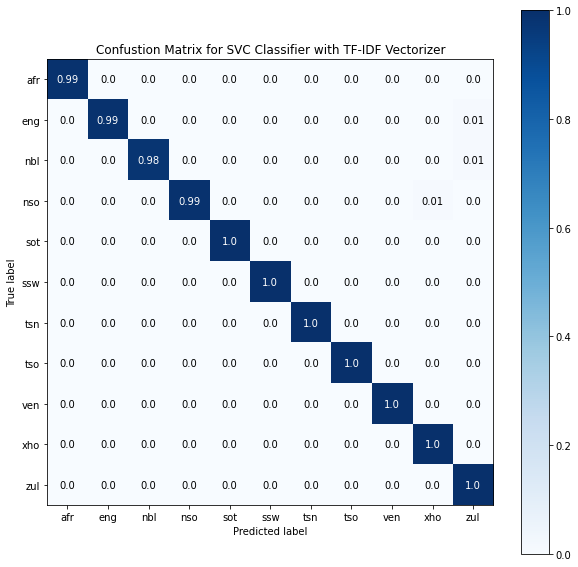

In [ ]:
print(classification_report(y_val,svc_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,svc_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for SVC Classifier with TF-IDF Vectorizer")

#####**Stochastic Gradient Descent Classifiers**

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      0.99      1.00       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       0.99      1.00      0.99       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.99      1.00      0.99       313
         zul       0.99      1.00      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for SGD Classifier with Count Vectorizer')

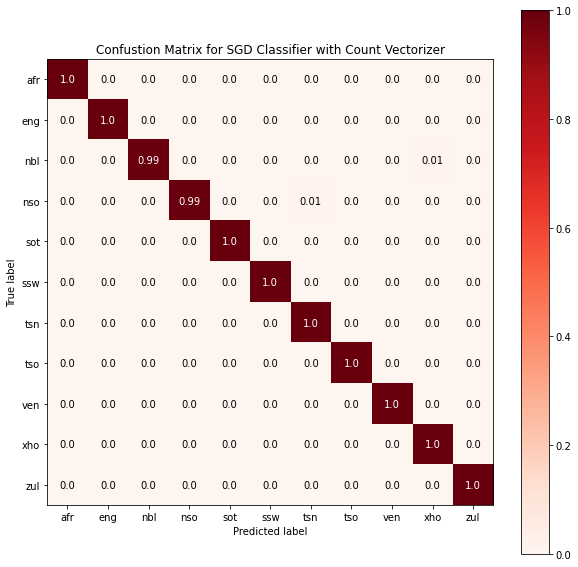

In [ ]:
print(classification_report(y_val,SGD_count.predict(X_val)))
plot_confusion_matrix(y_val,SGD_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for SGD Classifier with Count Vectorizer")

              precision    recall  f1-score   support

         afr       0.99      1.00      0.99       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      0.99      0.99       327
         nso       1.00      0.99      1.00       322
         sot       1.00      1.00      1.00       307
         ssw       0.99      0.99      0.99       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       0.99      1.00      1.00       313
         zul       0.99      0.99      0.99       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for SGD Classifier with TF-IDF Vectorizer')

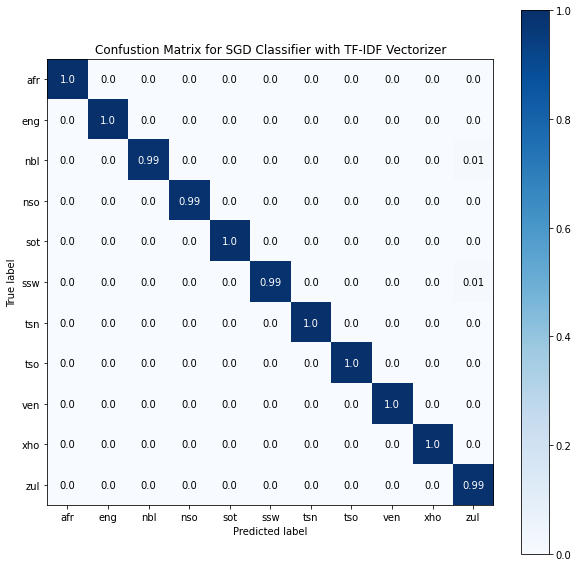

In [ ]:
print(classification_report(y_val,SGD_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,SGD_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for SGD Classifier with TF-IDF Vectorizer")

#####**Ridge Classifiers**

In [ ]:
print(classification_report(y_val,ridge_count.predict(X_val)))
plot_confusion_matrix(y_val,ridge_count.predict(X_val),normalize=True, figsize=(10,10),cmap=("Reds"))
plt.title("Confustion Matrix for Ridge Classifier with Count Vectorizer")

In [ ]:
print(classification_report(y_val,ridge_tfidf.predict(X_val)))
plot_confusion_matrix(y_val,ridge_tfidf.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for Ridge Classifier with TF-IDF Vectorizer")

###**Hyper parameter tuning Top Performing model**

#####**Naive Bayes Classifier with TF-IDF Vectorizer**

In [ ]:
naive_tfidf.get_params()

{'memory': None,
 'naive': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 'naive__alpha': 1.0,
 'naive__class_prior': None,
 'naive__fit_prior': True,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0,
                   max_features=180000, min_df=1, ngram_range=(1, 1), norm='l2',
                   preprocessor=None, smooth_idf=True, stop_words=None,
                   strip_accents=None, sublinear_tf=False,
                   token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                   vocabulary=None)),
  ('naive', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_d

In [ ]:
params={
    'tfidf__ngram_range': [(1, 1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8),(9,9),(10,10)],
    'naive__alpha':[0.001,0.01,0.1,1]
}
Kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
grid = GridSearchCV(naive_tfidf,param_grid=params,n_jobs=-1,cv=Kfold,verbose=3)

In [ ]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=180000,
                                                        min_df=1,
                                                        ngram

In [ ]:
model = grid.best_estimator_
print(grid.best_score_)

0.9991245791245792


              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       281
         eng       1.00      1.00      1.00       297
         nbl       1.00      1.00      1.00       327
         nso       1.00      0.99      1.00       322
         sot       0.99      1.00      1.00       307
         ssw       1.00      1.00      1.00       286
         tsn       1.00      1.00      1.00       297
         tso       1.00      1.00      1.00       253
         ven       1.00      1.00      1.00       322
         xho       1.00      1.00      1.00       313
         zul       1.00      1.00      1.00       295

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



Text(0.5, 1.0, 'Confustion Matrix for Hypertuned Naive bayes Classifier with Count Vectorizer')

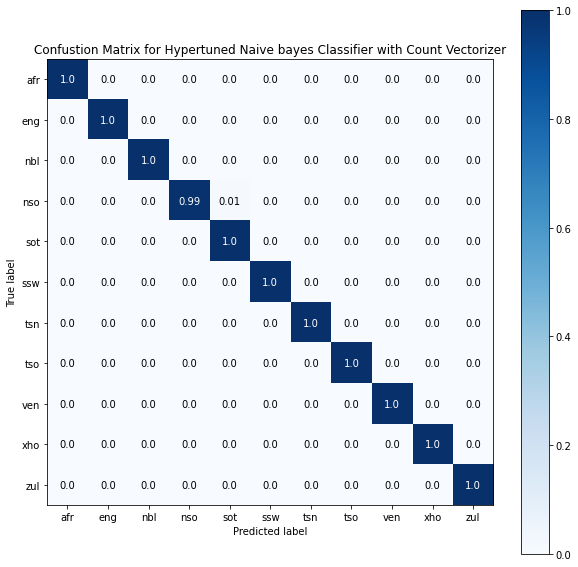

In [ ]:
print(classification_report(y_val,model.predict(X_val)))
plot_confusion_matrix(y_val,model.predict(X_val),normalize=True, figsize=(10,10),cmap=("Blues"))
plt.title("Confustion Matrix for Hypertuned Naive bayes Classifier with Count Vectorizer")

In [ ]:
test['lang_id'] = model.predict(X_test)

In [ ]:
test[['index','lang_id']].to_csv("submission.csv",index=False)